# One layer forex Nueral Network 
* Attempting to see whether a One hidden layer Neural Network will perform better than a logistical regression model

* result was it perform just a little bit better

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def sigmoid(z):
    """
    Compute the sigmoid of z
    Arguments:
    z -- A scalar or numpy array of any size.
    """
    return 1 / (1 + np.exp(-z))

In [3]:
df = pd.read_csv("./datasets/5_min_EUR_USD_2019_to_2023_mid_prices.csv")
df

,time,EUR_USD
0,2018-08-22 02:40:00+00:00,1.15758
1,2018-08-22 02:45:00+00:00,1.15750
2,2018-08-22 02:50:00+00:00,1.15726
3,2018-08-22 02:55:00+00:00,1.15746
4,2018-08-22 03:00:00+00:00,1.15746
...,...,...
372104,2023-08-22 08:15:00+00:00,1.09182
372105,2023-08-22 08:20:00+00:00,1.09184
372106,2023-08-22 08:25:00+00:00,1.09183
372107,2023-08-22 08:30:00+00:00,1.09174


In [4]:
symbol = 'EUR_USD'
features_col_names = ["price", 'returns', "dir"]
window = 50 # rolling window 
df["returns"] = np.log(df[symbol] / df[symbol].shift())
# if its positive we assign it [1] else negative [0]
# Since this is a logistic regression Binary classification model its best to predict either 0 or 1 we cant make it 
# make it predict -1 if the price went down
df['dir'] = np.where(df['returns'] > 0, 1, 0)
# sma strategy calculate the distance between sma 50 and sma 150
df.dropna(inplace = True)

In [5]:
def create_sequences(df, seq_length):
    X, y = [], []
    for i in range(0, len(df)-seq_length, seq_length):
        X.append(df[df.columns[1]].iloc[i:i+seq_length])
        y.append(df[df.columns[3]].iloc[i+seq_length - 1])
    return np.array(X), np.array(y)

In [6]:
X, y = create_sequences(df, 300)

In [7]:
X.shape # we have 24807 training examples 

(1240, 300)

In [8]:
y.shape

(1240,)

In [9]:
y

array([1, 1, 1, ..., 0, 0, 1])

In [10]:
# Standarize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train.shape, X_test.shape

((992, 300), (248, 300))

In [13]:
y_train.shape, y_test.shape

((992,), (248,))

In [14]:
train_set_x = X_train.reshape(X_train.shape[0], -1).T
test_set_x = X_test.reshape(X_test.shape[0], -1).T

In [15]:
train_set_x.shape, test_set_x.shape

((300, 992), (300, 248))

In [16]:
train_set_y = y_train.reshape(1, -1)
test_set_y = y_test.reshape(1, -1)
train_set_y.shape, test_set_y.shape

((1, 992), (1, 248))

In [17]:
print(f"""
train_set_x shape: {train_set_x.shape}
test_set_x shape: {test_set_x.shape}

train_set_y shape: {train_set_y.shape}
test_set_y shape: {test_set_y.shape}
""")


train_set_x shape: (300, 992)
test_set_x shape: (300, 248)

train_set_y shape: (1, 992)
test_set_y shape: (1, 248)



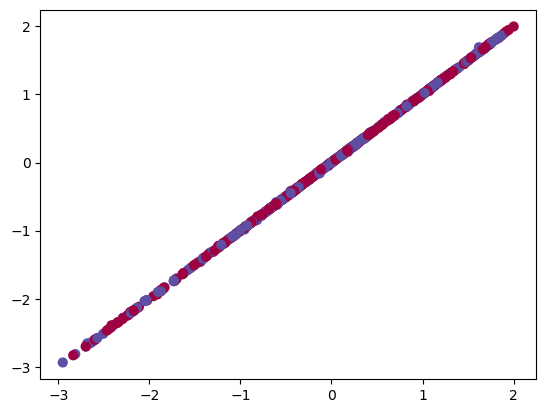

In [18]:
plt.scatter(train_set_x[0, :], train_set_x[1, :], c=train_set_y, s=40, cmap=plt.cm.Spectral);

### Simple logistic regression test

In [19]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV(max_iter=500_000);
clf.fit(train_set_x.T, train_set_y.T);

/Users/tonyavis/miniconda3/envs/AI_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
# Print accuracy
LR_predictions = clf.predict(train_set_x.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(train_set_y,LR_predictions) + np.dot(1-train_set_y,1-LR_predictions))/float(train_set_y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")
""" Not really sure y the accuracy is so high """

Accuracy of logistic regression: 97 % (percentage of correctly labelled datapoints)


/var/folders/kg/7xftw3_12y10ppg5bv5lb26w0000gn/T/ipykernel_84826/2783312128.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print ('Accuracy of logistic regression: %d ' % float((np.dot(train_set_y,LR_predictions) + np.dot(1-train_set_y,1-LR_predictions))/float(train_set_y.size)*100) +


' Not really sure y the accuracy is so high '

In [21]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    
    return (n_x, n_h, n_y)

In [22]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [23]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [24]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    
    m = Y.shape[1] # number of examples

    # Compute the cross-entropy cost
#     logprobs = np.multiply(np.log(A2),Y) + (1 - Y) * np.log(1 - A2)
# line above or below doesnt matter
    logprobs = np.multiply(np.log(A2),Y) + np.multiply((1-Y), np.log(1 - A2))
    cost = (-1/m) * np.sum(logprobs)  
    
    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    
    return cost

In [25]:

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [26]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve a copy of each parameter from the dictionary "parameters". Use copy.deepcopy(...) for W1 and W2
    W1 = copy.deepcopy(parameters["W1"])
    b1 = copy.deepcopy(parameters["b1"])
    W2 = copy.deepcopy(parameters["W2"])
    b2 = copy.deepcopy(parameters["b2"])
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = copy.deepcopy(grads["dW1"])
    db1 = copy.deepcopy(grads["db1"])
    dW2 = copy.deepcopy(grads["dW2"])
    db2 = copy.deepcopy(grads["db2"])
    
    
    # Update rule for each parameter
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [27]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop/ how many times the model sees the data
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)

        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [28]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X, parameters)
    # predictions = A2 > .5 #returns true or false
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))

    for i in range(A2.shape[1]):
        if A2[0, i] > .5 :
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
        
    return Y_prediction

In [29]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(train_set_x, train_set_y, n_h = 4, num_iterations = 10000, print_cost=True)

Cost after iteration 0: 0.693133
Cost after iteration 1000: 0.691715
Cost after iteration 2000: 0.691782
Cost after iteration 3000: 0.685438
Cost after iteration 4000: 0.704630
Cost after iteration 5000: 0.673596
Cost after iteration 6000: 0.662356
Cost after iteration 7000: 0.661190
Cost after iteration 8000: 0.641280
Cost after iteration 9000: 0.644193


In [30]:
predictions = predict(parameters, test_set_x)

In [31]:
test_set_y.shape, predictions.shape

((1, 248), (1, 248))

In [32]:
len(predictions[0])

248

In [33]:
matching_values = np.sum(predictions == test_set_y)

In [34]:
print(f"""Accuracy: {round(matching_values / len(predictions[0]) * 100, 2)}%""")

Accuracy: 58.06%


## Tuning

In [35]:
# This may take about 2 minutes to run
hidden_layer_sizes = [1, 2, 3, 4, 5, 100]

# you can try with different hidden layer sizes
# but make sure before you submit the assignment it its set as "hidden_layer_sizes = [1, 2, 3, 4, 5]"
# hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]

for i, n_h in enumerate(hidden_layer_sizes):
    parameters = nn_model(train_set_x, train_set_y, n_h, num_iterations = 5000)
    predictions = predict(parameters, test_set_x)
    matching_values = np.sum(predictions == test_set_y)
    accuracy = round(matching_values / len(predictions[0]) * 100, 2)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))


Accuracy for 1 hidden units: 57.66 %
Accuracy for 2 hidden units: 55.24 %
Accuracy for 3 hidden units: 54.44 %
Accuracy for 4 hidden units: 56.05 %
Accuracy for 5 hidden units: 45.97 %


/var/folders/kg/7xftw3_12y10ppg5bv5lb26w0000gn/T/ipykernel_84826/1920958308.py:19: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(np.log(A2),Y) + np.multiply((1-Y), np.log(1 - A2))
/var/folders/kg/7xftw3_12y10ppg5bv5lb26w0000gn/T/ipykernel_84826/1920958308.py:19: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(np.log(A2),Y) + np.multiply((1-Y), np.log(1 - A2))


Accuracy for 100 hidden units: 53.63 %
